### Import Libraries

In [1]:
import sklearn
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)

### Load Data

In [2]:
main_df = pd.read_csv('train.csv')
print(f"rows:{main_df.shape[0]} | columns:{main_df.shape[1]}")

rows:432600 | columns:18


In [3]:
main_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 432600 entries, 0 to 432599
Data columns (total 18 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   obs     432600 non-null  int64  
 1   sub_id  432600 non-null  int64  
 2   time    432600 non-null  object 
 3   num_0   432600 non-null  float64
 4   num_1   432600 non-null  int64  
 5   num_2   432600 non-null  int64  
 6   cat_0   432600 non-null  int64  
 7   cat_1   432600 non-null  int64  
 8   cat_2   432600 non-null  int64  
 9   cat_3   432600 non-null  int64  
 10  cat_4   432600 non-null  int64  
 11  t_0     432600 non-null  float64
 12  t_1     432600 non-null  float64
 13  t_2     432600 non-null  float64
 14  t_3     432600 non-null  float64
 15  t_4     432600 non-null  float64
 16  y_1     432600 non-null  float64
 17  y_2     432600 non-null  float64
dtypes: float64(8), int64(9), object(1)
memory usage: 59.4+ MB


In [4]:
(main_df.groupby('obs')['sub_id'].count() != 30).sum()

0

In [5]:
def check_unique_counts(df):
    col_name = []
    counts = []
    for col in df.columns:
        col_name.append(col)
        counts.append(df[col].nunique())
    d = {'columns': col_name, 'unique_count': counts}
    dff = pd.DataFrame(d).sort_values(by='unique_count', ascending=False)
    return dff

In [6]:
check_unique_counts(main_df)

,columns,unique_count
2,time,432352
0,obs,14420
13,t_2,9424
15,t_4,7433
11,t_0,5972
17,y_2,5601
14,t_3,5462
16,y_1,4706
12,t_1,1622
1,sub_id,1596


In [7]:
main_df['obs'].nunique()

14420

### Initial Observations
- There are total 14420 unique observations
- Each 'obs' has 30 records
- There are no null values in data
- There are 4 binary variables i.e. `cat_0` - `cat_3`
- `cat_1` variable has 5 categories
- There are 5 continuos variables i.e. `t_0` - `t_4`
- There are two target variables i.e. `y_1` and `y_2`

In [8]:
(main_df.groupby('obs')['num_0', 'num_1', 'num_2', 'y_1', 'y_2'].count() != 30).sum()

num_0    0
num_1    0
num_2    0
y_1      0
y_2      0
dtype: int64

- An interesting observation about variable `num_0, num_1, num_2, y_1 and y_2` is that for all 30 records of an observation, value doesn't change.

## EDA

In [9]:
t_cols = ['t_0', 't_1', 't_2', 't_3', 't_4']
target_cols = ['y_1', 'y_2']
cat_cols = ['cat_0', 'cat_1', 'cat_2', 'cat_3', 'cat_4']

**Distribution of continuous variables**

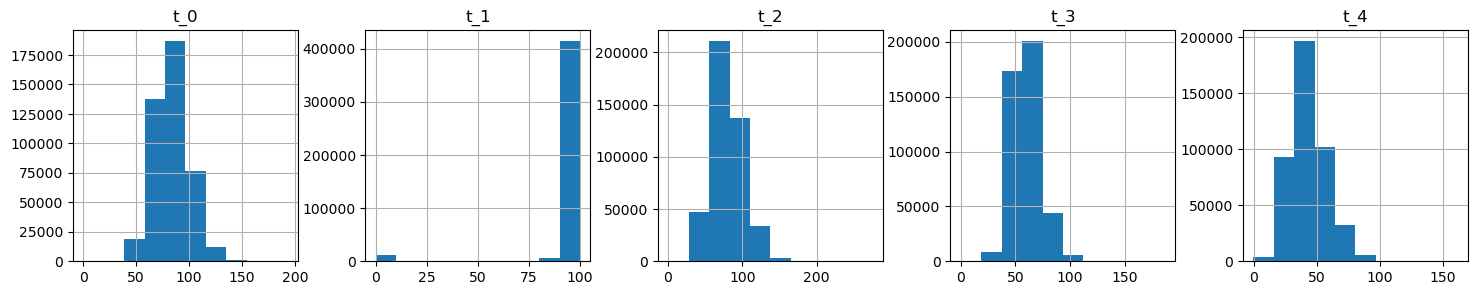

In [10]:
main_df[t_cols].hist(layout=(1,5), figsize=(18,3))
plt.show()

**Distribution of categorical variables**

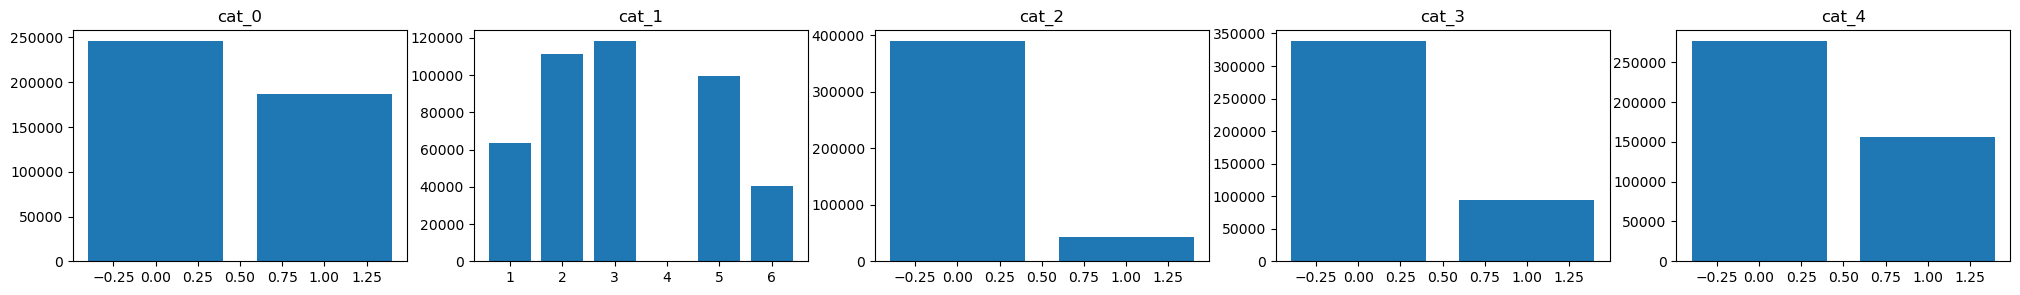

In [11]:
fig, axs = plt.subplots(1, 5, figsize=(25, 3))

for i in range(5):
    col_name = 'cat_' + str(i)
    val_counts = main_df[col_name].value_counts()
    axs[i].bar( val_counts.index, val_counts.values)
    axs[i].set_title(col_name)
plt.show()

**Distribution of target variables**

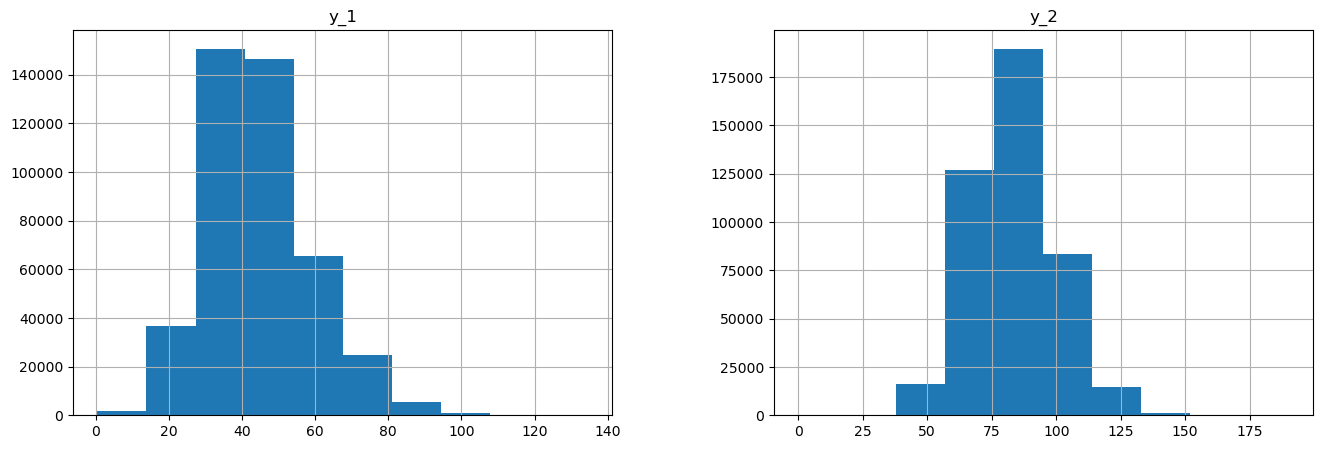

In [12]:
main_df[target_cols].hist(layout=(1,2), figsize=(16,5))
plt.show()

## Data Processing

In [13]:
train_df = main_df.copy()

In [14]:
train_df['time'] = pd.to_datetime(train_df['time'])

**drop irrelevant columns**

In [15]:
train_df = train_df.drop(columns=['sub_id', 'time'])
train_df.shape

(432600, 16)

**create dummy variables**

In [16]:
train_df = pd.get_dummies(train_df, columns=['cat_0', 'cat_1','cat_2', 'cat_3', 'cat_4'])

In [18]:
X_train, X_val, y_train, y_val = train_test_split( train_df.drop(['y_1','y_2','obs'], axis=1), 
                                                   train_df[['y_1','y_2']],
                                                   test_size=0.3, random_state=42
                                                  )

In [19]:
X_train.shape

(302820, 21)

## Linear Model

In [20]:
from sklearn.linear_model import Lasso
lasso = Lasso()
lasso.fit(X_train, y_train)

y_val_pred = lasso.predict(X_val)
print(mean_absolute_error(y_val, y_val_pred))

5.436609688938629


### Hyperparameter tuning

In [21]:
lasso = Lasso()
hyperparameters = { 'alpha': np.arange(0.1, 1, 0.1) }
grid_search = GridSearchCV(lasso, hyperparameters, scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'alpha': 0.1}
Best score: -5.404511978244486


In [22]:
lasso = Lasso(alpha=grid_search.best_params_['alpha'])
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
y_val_pred = lasso.predict(X_val)
print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

Training MAE: 5.404327298666299
Validation MAE: 5.420778737532634


## Boosting

In [23]:
xgb_regressor = xgb.XGBRegressor()
xgb_regressor.fit(X_train, y_train)

y_train_pred = xgb_regressor.predict(X_train)
y_val_pred = xgb_regressor.predict(X_val)

print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

Training MAE: 4.428034492837533
Validation MAE: 4.556016920551876


### Hyperparameter tuning

In [24]:
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5],
    'n_estimators': [50, 100],
    'min_child_weight': [1, 3]
}

In [27]:
grid_search = GridSearchCV(xgb_regressor, param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    callbacks=None, colsample_bylevel=1,
                                    colsample_bynode=1, colsample_bytree=1,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=0, gpu_id=-1, grow_policy='depthwise',
                                    importance_type=None,
                                    interaction_constraints='',
                                    learning_rate=0.300000012, max_bin=256,
                                    max_cat_to_onehot=4, max_delta_step=0,
                                    max_depth=6, max_leaves=0,
                                    min_child_weight=1, missing=nan,
                                    monotone_constraints='()', n_estimators=100,
                                    n_jobs=0, num_parallel_tree=1,
                                    predictor='auto', random_state=0,
                                    reg_alpha=0, reg_lambda=1, ...),
             param_grid={'learning_rate': [0.1, 0.01], 'max_depth': [3, 5],
                         'min_child_weight': [1, 3],
                         'n_estimators': [50, 100]})

In [28]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 100}
Best score: 0.7565086669417461


In [57]:
param_grid = {
    'learning_rate': grid_search.best_params_['learning_rate'],
    'max_depth': grid_search.best_params_['max_depth'],
    'n_estimators': grid_search.best_params_['min_child_weight'],
    'min_child_weight': min_child_weight['n_estimators']
}

In [ ]:
xgb_regressor = xgb.XGBRegressor(param_grid)
xgb_regressor.fit(X_train, y_train)

y_train_pred = xgb_regressor.predict(X_train)
y_val_pred = xgb_regressor.predict(X_val)

print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
print("Validation MAE:", mean_absolute_error(y_val, y_val_pred))

## Approach 1: Data Aggregation

In [29]:
grouped = main_df.copy()
grouped = grouped.groupby(grouped.obs).mean()

for col in grouped.columns:
    if col.startswith('cat'):
        grouped[col] = grouped[col].astype("category")
        
grouped = pd.get_dummies(grouped)

X_train, X_val, y_train, y_val = train_test_split(
                                    grouped.drop(['y_1','y_2'], axis=1), 
                                    grouped[['y_1','y_2']], test_size=0.3, random_state=42)

In [30]:
lasso = Lasso()
hyperparameters = { 'alpha': np.arange(0.1, 1, 0.1) }
grid_search = GridSearchCV(lasso, hyperparameters, scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'alpha': 0.1}
Best score: -4.717304842184112


## Approach 2: Data Transformation

**Since for one observation, values in columns doesn't change except t_0 - t_4; we group by the rest of the columns on observation and created wide dataframe on 4 columns i.e. t_0 - t_4**

In [31]:
def create_wide_df(train_val, unique_obs, cols=None):
    
    """ Function to create wide dataframe
    It creates a dictionary where key is an observation 
    and value is a list of values from columns t_0 - t_4 
    appended into one array. 
    obs: np.array(150 values because 5 columns and 30 values in each column for one `obs`)
    """
    
    temp_cols = cols[1:]
    d = {}
    for obs in unique_obs:
        lst = []
        temp_df = None
        temp_df = train_val[train_val['obs'] == obs][cols]#.copy()
        for col in temp_cols:
            lst.append(temp_df[col].tolist())
        d[obs] = np.array(lst).flatten()

    return d, pd.DataFrame(d).T

In [32]:
def manuplate_df(df, dataset_type='Train'):
    
    cols_1 = ['obs', 'num_0', 'num_1', 'num_2', 'cat_0', 'cat_1', 'cat_2', 'cat_3', 'cat_4', 'y_1', 'y_2']
    cols_2 = ['obs', 't_0', 't_1', 't_2', 't_3', 't_4']
    
    if dataset_type == 'Test':
        cols_1 = [i for i in cols_1 if i not in ('y_1', 'y_2')]

    half_1_df = df[cols_1].copy().set_index('obs')
    half_1_agg_df = half_1_df.groupby('obs').mean()
    
    unique_obs = list(set(df['obs'].tolist()))
    d, man_df = create_wide_df(df, unique_obs, cols = cols_2)
    col_names = [ 'col_' + str(i) for i in range(len(man_df.columns))]
    man_df.columns = col_names
    
    final_df = pd.concat([half_1_agg_df, man_df], axis=1)
    
    return final_df

In [33]:
train_df = main_df.copy()
manu_train_df = manuplate_df(train_df, dataset_type='Train')

In [34]:
def get_dummies(df, col=None):
    for col in df.columns:
        if col.startswith('cat'):
            df[col] = df[col].astype("category")
    df = pd.get_dummies(df)
    return df

In [35]:
manu_train_df = get_dummies(manu_train_df)

In [36]:
X_train, X_val, y_train, y_val = train_test_split(
                                    manu_train_df.drop(['y_1','y_2'], axis=1), 
                                    manu_train_df[['y_1','y_2']], test_size=0.3, random_state=42)

In [37]:
lasso = Lasso()
hyperparameters = { 'alpha': np.arange(0.1, 1, 0.1) }
grid_search = GridSearchCV(lasso, hyperparameters, scoring = 'neg_mean_absolute_error')
grid_search.fit(X_train, y_train)

print("Best hyperparameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best hyperparameters: {'alpha': 0.7000000000000001}
Best score: -4.263801079431115


In [38]:
lasso = Lasso(alpha=grid_search.best_params_['alpha'])
lasso.fit(X_train, y_train)

y_train_pred = lasso.predict(X_train)
y_val_pred = lasso.predict(X_val)
print("Training MAE", mean_absolute_error(y_train, y_train_pred))
print("Validation MAE", mean_absolute_error(y_val, y_val_pred))

Training MAE 4.239514250150114
Validation MAE 4.20181051894314


### SVR Model

**Taking a look at modified columns from original t_ columns and the target**

In [39]:
mod_cols = ['col_' + str(i) for i in range(150)]

<AxesSubplot: >

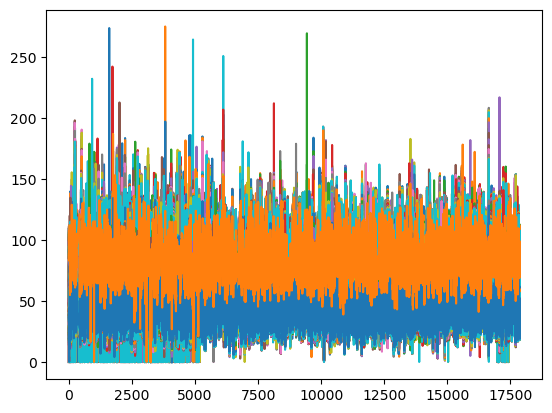

In [40]:
manu_train_df[mod_cols + target_cols].plot(legend=False)

In [60]:
X_train, X_val, y1_train, y1_val = train_test_split(
                                    manu_train_df.drop(['y_1','y_2'], axis=1), 
                                    manu_train_df[['y_1']], test_size=0.2, random_state=42)

X_train, X_val, y2_train, y2_val = train_test_split(
                                    manu_train_df.drop(['y_1','y_2'], axis=1), 
                                    manu_train_df[['y_2']], test_size=0.2, random_state=42)

In [65]:
hyperparameters = { 'linearsvr__C': np.arange(0.1, 1, 0.1),
                    'linearsvr__tol': [0.001, 0.0001, 0.00001] }


svr_pipeline = make_pipeline(StandardScaler(), LinearSVR())
grid_search_y1 = GridSearchCV(svr_pipeline, hyperparameters, scoring = 'neg_mean_absolute_error')

grid_search_y1.fit(X_train, y1_train)

print("Best hyperparameters for y_1:", grid_search_y1.best_params_)
print("Best score for y_1:", grid_search_y1.best_score_)

grid_search_y2 = GridSearchCV(svr_pipeline, hyperparameters, scoring = 'neg_mean_absolute_error')
grid_search_y2.fit(X_train, y2_train)

print("Best hyperparameters for y_2:", grid_search_y2.best_params_)
print("Best score for y_2:", grid_search_y2.best_score_)

Best hyperparameters for y_1: {'linearsvr__C': 0.2, 'linearsvr__tol': 1e-05}
Best score for y_1: -4.9593146907364245
Best hyperparameters for y_2: {'linearsvr__C': 0.8, 'linearsvr__tol': 1e-05}
Best score for y_2: -3.3054956827421114


In [67]:
svr_pipeline_y1 = make_pipeline(StandardScaler(), LinearSVR(random_state=0, C=grid_search_y1.best_params_['linearsvr__C'], tol=grid_search_y1.best_params_['linearsvr__tol']))

svr_y1 = svr_pipeline_y1.fit(X_train, y1_train)
svr_train_y1_pred = svr_y1.predict(X_train)
svr_val_y1_pred = svr_y1.predict(X_val)

svr_pipeline_y2 = make_pipeline(StandardScaler(), LinearSVR(random_state=0, C=grid_search_y2.best_params_['linearsvr__C'], tol=grid_search_y1.best_params_['linearsvr__tol']))
svr_y2 = svr_pipeline_y2.fit(X_train, y2_train)
svr_train_y2_pred = svr_y2.predict(X_train)
svr_val_y2_pred = svr_y2.predict(X_val)


In [68]:
print("Training MAE:", mean_absolute_error(np.array([y1_train['y_1'].values, y2_train['y_2'].values]),
                                          np.array([svr_train_y1_pred, svr_train_y2_pred])))

print("Validation MAE: ", mean_absolute_error(np.array([y1_val['y_1'].values, y2_val['y_2'].values]),
                                          np.array([svr_val_y1_pred, svr_val_y2_pred])))


Training MAE: 4.117631963235068
Validation MAE:  4.018147368665255
